In [2]:
import cv2
import pytesseract
import matplotlib.pyplot as plt
import os
import numpy as np

video_path = os.path.join(os.getcwd(), 'data', 'input', '10 menit 1 November.mp4')

In [3]:
frame_number = 9923

cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
ret, frame = cap.read()
cap.release()

height, width, _ = frame.shape
real = frame.copy()


frame_bytes = real.nbytes
frame_mb = frame_bytes / (1024 * 1024)
print(f"Frame size: {frame_mb:.2f} MB")

Frame size: 0.99 MB


## Tahap 1: Region of Interest (ROI) Extraction
Mengidentifikasi ROI pada 10% area bawah layar untuk mendapatkan potongan citra yang memuat teks berjalan.

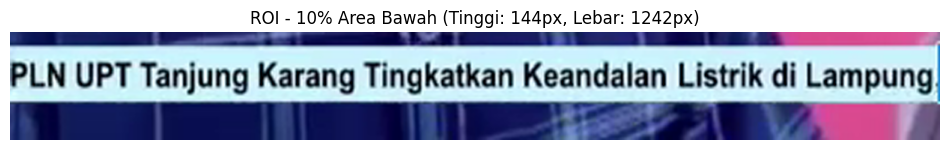

Ukuran frame asli: 480x720
Ukuran ROI: 144x1242
Ukuran penyimpanan ROI dalam memory: 0.51 MB


In [5]:
# 1. ROI Extraction - 10% area bawah layar
height, width = frame.shape[:2]
roi = frame[int(0.9 * height):height, :, :].copy()

left_crop = 179  
right_crop = 127  
refined_roi = roi[:, left_crop:width-right_crop, :].copy()

resized_roi = cv2.resize(refined_roi, (0,0), fx=3, fy=3, interpolation=cv2.INTER_CUBIC)

# Visualisasi ROI
plt.figure(figsize=(12, 3))
plt.imshow(cv2.cvtColor(resized_roi, cv2.COLOR_BGR2RGB))
plt.title(f'ROI - 10% Area Bawah (Tinggi: {resized_roi.shape[0]}px, Lebar: {resized_roi.shape[1]}px)')
plt.axis('off')
plt.show()

print(f"Ukuran frame asli: {height}x{width}")
print(f"Ukuran ROI: {resized_roi.shape[0]}x{resized_roi.shape[1]}")

roi_size_bytes = resized_roi.nbytes
roi_size_mb = roi_size_bytes / (1024 * 1024)
print(f"Ukuran penyimpanan ROI dalam memory: {roi_size_mb:.2f} MB")

## Tahap 2: Filtering - Median Blur
Mengurangi noise dengan median blur untuk mempersiapkan citra sebelum thresholding.

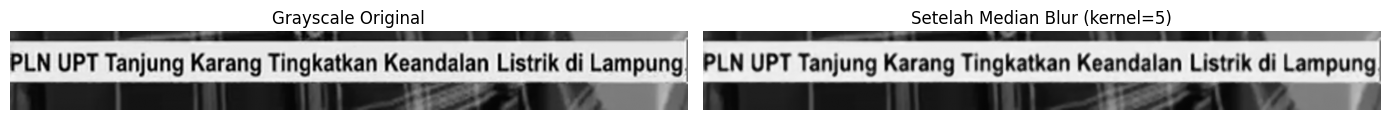

In [10]:
# 2. Filtering - Median Blur untuk mengurangi noise
# Konversi ke grayscale terlebih dahulu
gray = cv2.cvtColor(resized_roi, cv2.COLOR_BGR2GRAY)

# Median Blur dengan kernel 3x3
filtered = cv2.medianBlur(gray, 5)

# Visualisasi perbandingan
fig, axes = plt.subplots(1, 2, figsize=(14, 3))

axes[0].imshow(gray, cmap='gray')
axes[0].set_title('Grayscale Original')
axes[0].axis('off')

axes[1].imshow(filtered, cmap='gray')
axes[1].set_title('Setelah Median Blur (kernel=5)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Tahap 3: Thresholding - Otsu's Method
Memaksimalkan kontras dengan Otsu thresholding untuk memisahkan teks dari background secara optimal.

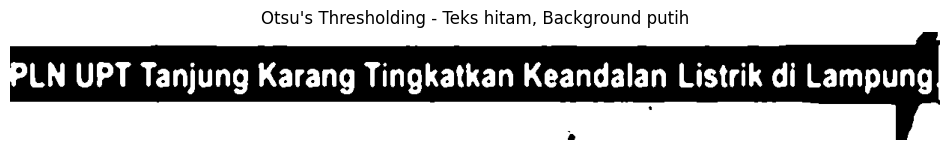

Threshold value yang dipilih Otsu: Otomatis optimal


In [11]:
# 3. Thresholding - Otsu's Method untuk memaksimalkan kontras
# Otsu thresholding secara otomatis menentukan threshold optimal
_, thresh = cv2.threshold(filtered, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Visualisasi hasil thresholding
plt.figure(figsize=(12, 3))
plt.imshow(thresh, cmap='gray')
plt.title("Otsu's Thresholding - Teks hitam, Background putih")
plt.axis('off')
plt.show()

print(f"Threshold value yang dipilih Otsu: Otomatis optimal")

## Tahap 4: Morphological Closing
Menyambungkan fragmen teks yang terputus menggunakan operasi morphological closing agar karakter memiliki bentuk utuh dan jelas.

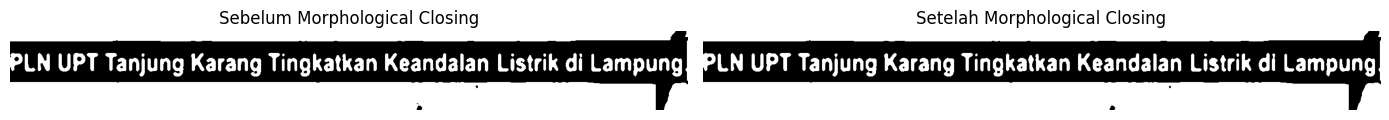

Morphological Closing: Fragmen teks tersambung, karakter lebih utuh


In [12]:
# 4. Morphological Closing - Menyambungkan fragmen teks yang terputus
# Closing = Dilasi kemudian Erosi (menutup celah kecil dalam karakter)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)

# Visualisasi perbandingan sebelum dan sesudah closing
fig, axes = plt.subplots(1, 2, figsize=(14, 3))

axes[0].imshow(thresh, cmap='gray')
axes[0].set_title('Sebelum Morphological Closing')
axes[0].axis('off')

axes[1].imshow(closed, cmap='gray')
axes[1].set_title('Setelah Morphological Closing')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("Morphological Closing: Fragmen teks tersambung, karakter lebih utuh")

## Tahap 5: OCR Tesseract - Text Extraction
Ekstraksi teks menggunakan Tesseract OCR dengan mode satu baris (PSM 7) yang optimal untuk running text, kemudian normalisasi untuk menghasilkan teks akhir yang bersih.

HASIL OCR - Teks Running Text:
PLN UPT Tanjung Karang Tingkatkan Keandalan Listrik di Lampung
Panjang teks: 62 karakter


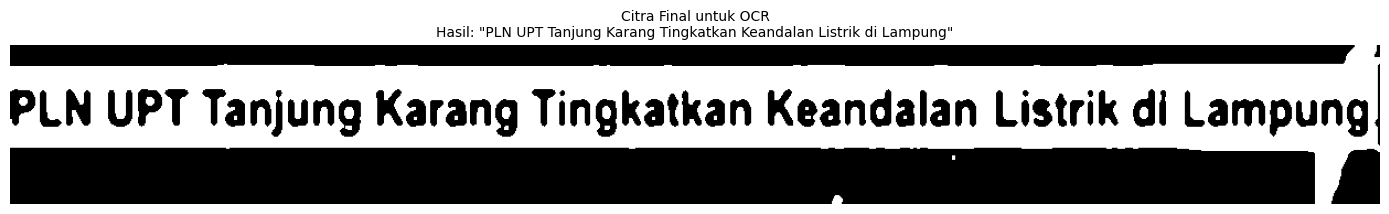

In [13]:
# 5. OCR Tesseract - Ekstraksi teks dengan mode satu baris (PSM 7)
# Inversi citra agar teks hitam di background putih untuk OCR
ocr_ready = cv2.bitwise_not(closed)

# Konfigurasi Tesseract:
# --oem 1: LSTM OCR Engine (akurasi terbaik)
# --psm 7: Single text line mode (optimal untuk running text)
# -l ind: Bahasa Indonesia
custom_config = r'--oem 1 --psm 13 -l ind'

# Ekstraksi teks
text = pytesseract.image_to_string(ocr_ready, config=custom_config)

# Normalisasi teks: Hapus spasi berlebih dan karakter noise
import re
text_normalized = text.strip()
text_normalized = ' '.join(text_normalized.split())  # Hapus multiple spaces
text_normalized = re.sub(r'[|~`]', '', text_normalized)  # Hapus karakter noise umum

# Tampilkan hasil
print("="*70)
print("HASIL OCR - Teks Running Text:")
print("="*70)
print(text_normalized)
print("="*70)
print(f"Panjang teks: {len(text_normalized)} karakter")

# Visualisasi hasil akhir
plt.figure(figsize=(14, 3))
plt.imshow(ocr_ready, cmap='gray')
plt.title(f'Citra Final untuk OCR\nHasil: "{text_normalized}"', fontsize=10)
plt.axis('off')
plt.tight_layout()
plt.show()